# Forecasting taxi orders
A taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, you need to forecast the number of taxi orders for the next hour. It is necessary to build a model for such a prediction.

The value of the metric "RMSE" in the test sample should not exceed 48.

You need to:

1. Upload the data and resample them one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-processing</a></span></li><li><span><a href="#Analysis-of-the-data" data-toc-modified-id="Analysis-of-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis of the data</a></span><ul class="toc-item"><li><span><a href="#Trend-and-seasonality" data-toc-modified-id="Trend-and-seasonality-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Trend and seasonality</a></span></li><li><span><a href="#Add-features" data-toc-modified-id="Add-features-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Add features</a></span></li></ul></li><li><span><a href="#Learning" data-toc-modified-id="Learning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Learning</a></span><ul class="toc-item"><li><span><a href="#Determining-the-required-number-of-features-using-Linear-regression" data-toc-modified-id="Determining-the-required-number-of-features-using-Linear-regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Determining the required number of features using Linear regression</a></span></li><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Linear regression</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#Gradient-Boosting-(LightGBM)" data-toc-modified-id="Gradient-Boosting-(LightGBM)-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Gradient Boosting (LightGBM)</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#General-conclusion" data-toc-modified-id="General-conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>General conclusion</a></span></li></ul></div>

## Pre-processing

In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb

In [4]:
df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0]) 
display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# resampling by 1 hour
df.sort_index(inplace=True)
df = df.resample('1H').sum()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C4825AEE80>]],
      dtype=object)

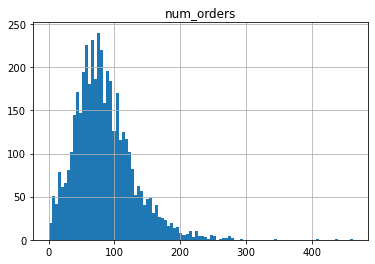

In [6]:
df.hist(bins=100)

## Analysis of the data

In [7]:
data = df.copy()

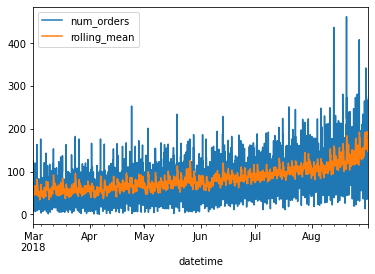

In [8]:
data['rolling_mean'] = data.rolling(15).mean()
data.plot()
plt.show()

A trend is clearly seen. Let us use statistical methods to investigate this behavior.

### Trend and seasonality

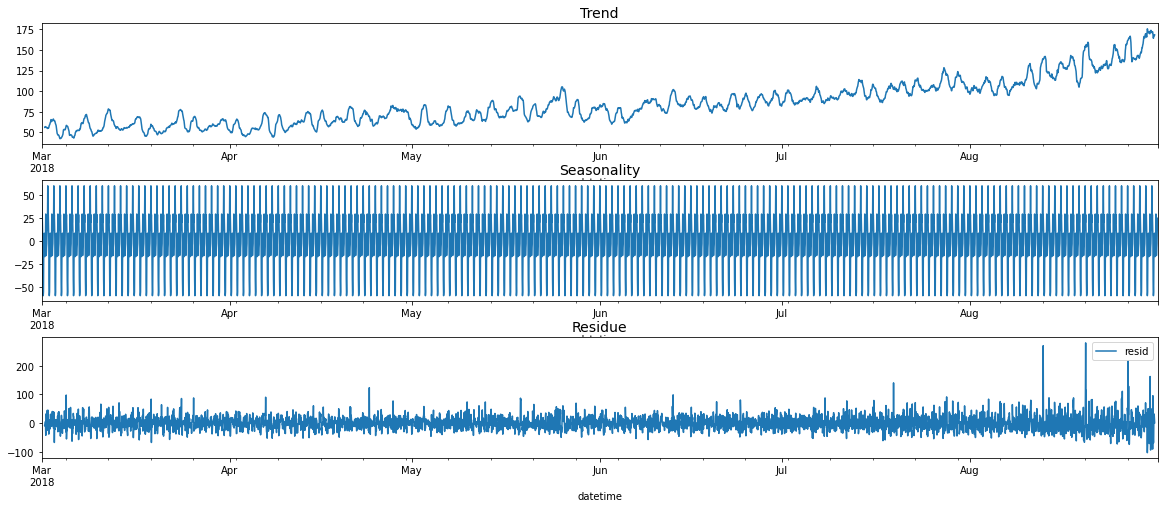

In [32]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(20,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend', size=14)
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality', size=14)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residue', size=14)

plt.subplots_adjust(wspace=1, hspace=.3)
plt.show()

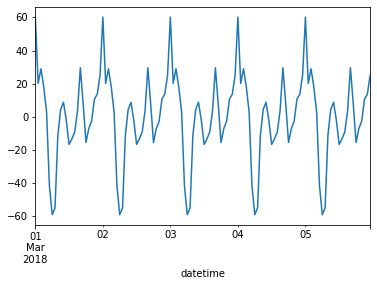

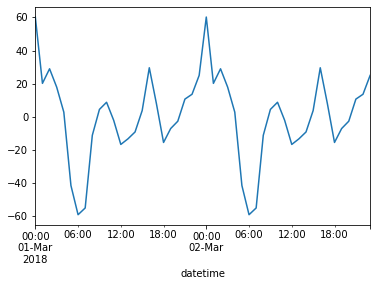

In [33]:
decomposed.seasonal['2018-03-01':'2018-03-05'].plot()
plt.show()
decomposed.seasonal['2018-03-01':'2018-03-02'].plot()
plt.show()

There is a daily cycle. Most activity is usually at 00:00 and 06:00.


### Add features
Let's add calendar features, lagged values and rolling average

In [34]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].rolling(rolling_mean_size, closed='left').mean()
    df= df.dropna()
    return df

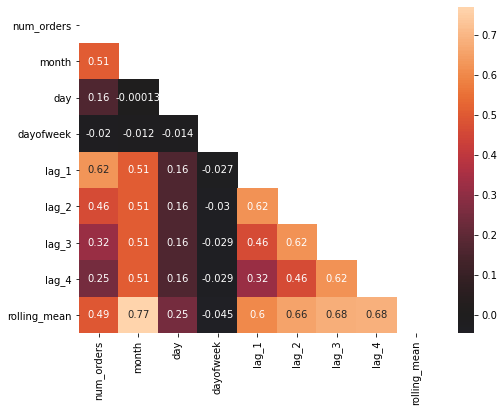

In [35]:
df_with_features = make_features(df, 4, 10)
df_with_features.head()

plt.figure(figsize=(8, 6))
corr = df_with_features.corr()
matrix = np.triu(corr)
sns.heatmap(corr, center=0, annot=True, mask=matrix)

The number of orders in a certain hour correlates well with the month of the trip, the number of trips in the last two hours, and the moving average.

## Learning
### Determining the required number of features using Linear regression

In [31]:
lags = range(1,25)
rolling_sizes = range(1,25)
rmse=[]
вtscv= TimeSeriesSplit()

tscv= TimeSeriesSplit()
model = LinearRegression()

for lag in lags:
    for rolling_size in rolling_sizes:
        data_new = make_features(data, lag, rolling_size)      
        gridsearch = GridSearchCV(model, param_grid={}, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=7)
        search = gridsearch.fit(data_new.drop(['num_orders'], axis=1), data_new['num_orders'])
        rmse.append(-search.best_score_)   

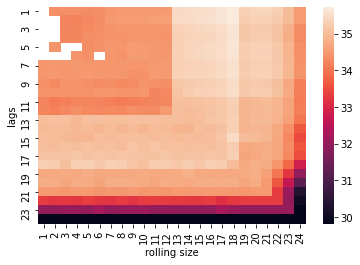

In [37]:
rmse_results = pd.DataFrame(data=np.array(rmse).reshape(len(lags), len(rolling_sizes)), columns=rolling_sizes, index=lags)
sns.heatmap(rmse_results[rmse_results<100])
plt.xlabel('rolling size')
plt.ylabel('lags')
plt.show()

We will use the lagged values from the previous 6 hours and the moving average from the previous 24 hours.

In [40]:
df_with_features = make_features(df, max_lag=24, rolling_mean_size=24)
display(df_with_features.head())

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


In [41]:
#cross-validation
tscv= TimeSeriesSplit()

#features and target separation
X, y = df_with_features.drop(['num_orders'], axis=1), df_with_features['num_orders']

### Linear regression

Learning with TimeSeriesSplit cross-validation to avoif laerning on the future data:

In [42]:
model = LinearRegression()

gridsearch = GridSearchCV(model, param_grid={}, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=7)
search = gridsearch.fit(X, y)
print(-search.best_score_) 

29.848378793992623


### RandomForest

In [79]:
%%time
model = RandomForestRegressor(random_state=25)

params = dict(n_estimators=range(10,101,30), max_depth=range(1, 16))
gridsearch = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=7)
search = gridsearch.fit(X, y)

print('best parameters:',search.best_params_)
print('best RMSE:', -search.best_score_)

best parameters: {'max_depth': 13, 'n_estimators': 100}
best RMSE: 28.67019395125273
Wall time: 50 s


### Gradient Boosting (LightGBM)

In [80]:
%%time
callbacks = [lgb.log_evaluation(period=0)]
model = lgb.LGBMRegressor(random_state=25, objective='rmse')

params = dict(n_estimators=range(100,1001,100), max_depth=range(1, 16), learning_rate=[0.01, 0.02, 0.05, 0.1])
gridsearch = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)
search = gridsearch.fit(df_with_features.drop(['num_orders'], axis=1), df_with_features['num_orders'])

print('best parameters:',search.best_params_)
print('best RMSE:', -search.best_score_)

best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
best RMSE: 28.126031507567717
Wall time: 4min 25s


### Conclusion
Gradient boosting (LightGBM) shows the best quality on training data (RMSE=28.1). We will use it for testing with the following parameters:

`{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}`

## Testing

In [81]:
#splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [82]:
callbacks = [lgb.log_evaluation(period=1)]
model = lgb.LGBMRegressor(random_state=25, objective='rmse', **{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300})
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('RMSE:',round(mean_squared_error(y_pred, y_test)**0.5, 2))

RMSE: 41.18


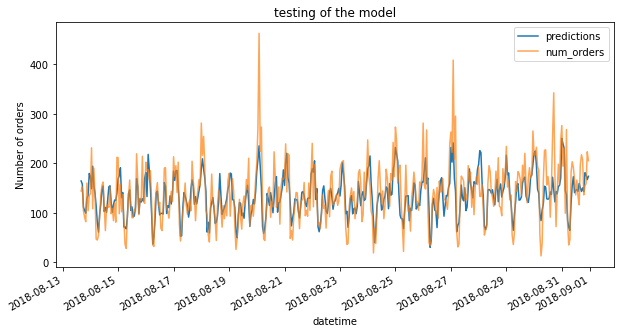

In [84]:
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_pred, label='predictions', alpha=1)
y_test.plot( alpha=0.7)
plt.title('testing of the model')
plt.ylabel('Number of orders')
plt.legend()
plt.show()

### Conclusion
Gradient boosting with fitted parameters on the test set shows RMSE = 52.9.

## General conclusion
We analyzed a dataset with the number of taxi orders for six months (time series). The data was resampled with an interval of 1 hour. 24 lagged features and a moving average calculated over the last 24 hours were added to the time series. Linear regression, random forest, gradient boosting (lightgbm and Catboost) models with hyperparameter fitting were trained on the training set. The best quality on the training data was shown by the LightGBM model with hyperparameters `{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}` and RMSE=28.1. On test data, this model showed the value of the RMSE quality metrics equal to 41.2.